WAVELET + LSTM/GRU

Using device: cuda
Model type: LSTM


/tmp/ipython-input-3-4212229878.py:45: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)


Successfully downloaded 1398 rows of data.
Preprocessing data...
Data normalized and denoised.
Data split sizes:
Train: 1083 | Validation: 121 | Test: 134

--- Model Architecture ---
StockPredictor(
  (model): LSTM(1, 50, num_layers=2, batch_first=True, dropout=0.2)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

--- Starting Model Training ---
Epoch 1/100 | Train Loss: 0.095583 | Val Loss: 0.115760
Validation loss decreased. Saving model to best_stock_predictor.pth
Epoch 2/100 | Train Loss: 0.021682 | Val Loss: 0.001382
Validation loss decreased. Saving model to best_stock_predictor.pth
Epoch 3/100 | Train Loss: 0.003111 | Val Loss: 0.000999
Validation loss decreased. Saving model to best_stock_predictor.pth
Epoch 4/100 | Train Loss: 0.001266 | Val Loss: 0.001521
Epoch 5/100 | Train Loss: 0.001040 | Val Loss: 0.001583
Epoch 6/100 | Train Loss: 0.000959 | Val Loss: 0.000965
Validation loss decreased. Saving model to best_stock_predictor.pth
Epoch 7/100 | Train Loss: 0.

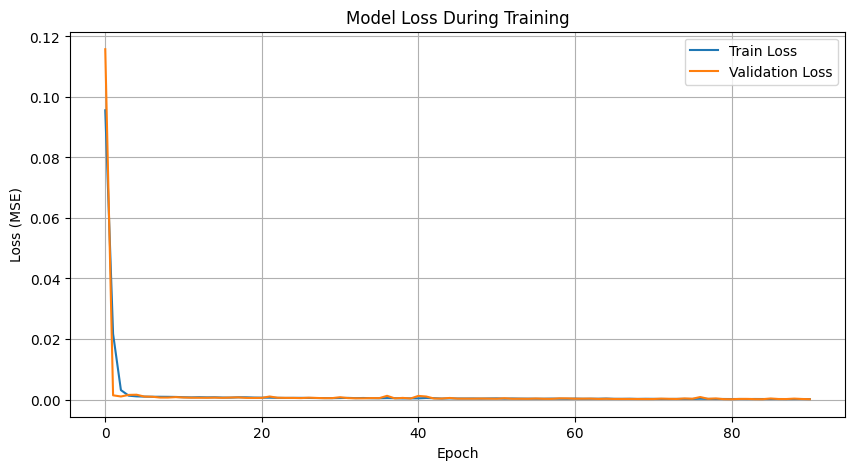


--- Final Model Evaluation ---

--- Training Set Metrics ---
RMSE: 1.8162
MAE:  1.3117
R2 Score: 0.9981
MAPE: 1.16%

--- Validation Set Metrics ---
RMSE: 1.9680
MAE:  1.6316
R2 Score: 0.9408
MAPE: 0.90%

--- Sample Test Set Predictions vs Actuals ---
Actual: $183.80, Predicted: $181.82
Actual: $184.74, Predicted: $183.11
Actual: $186.11, Predicted: $184.50
Actual: $186.98, Predicted: $185.84
Actual: $187.37, Predicted: $186.94
Actual: $187.62, Predicted: $187.64
Actual: $187.50, Predicted: $187.90
Actual: $187.73, Predicted: $187.74
Actual: $188.34, Predicted: $187.38
Actual: $188.80, Predicted: $187.16
Actual: $189.26, Predicted: $187.27
Actual: $189.53, Predicted: $187.79
Actual: $189.52, Predicted: $188.57
Actual: $189.44, Predicted: $189.34
Actual: $189.22, Predicted: $189.84

--- Test Set Metrics ---
RMSE: 2.3938
MAE:  1.6038
R2 Score: 0.9822
MAPE: 0.81%


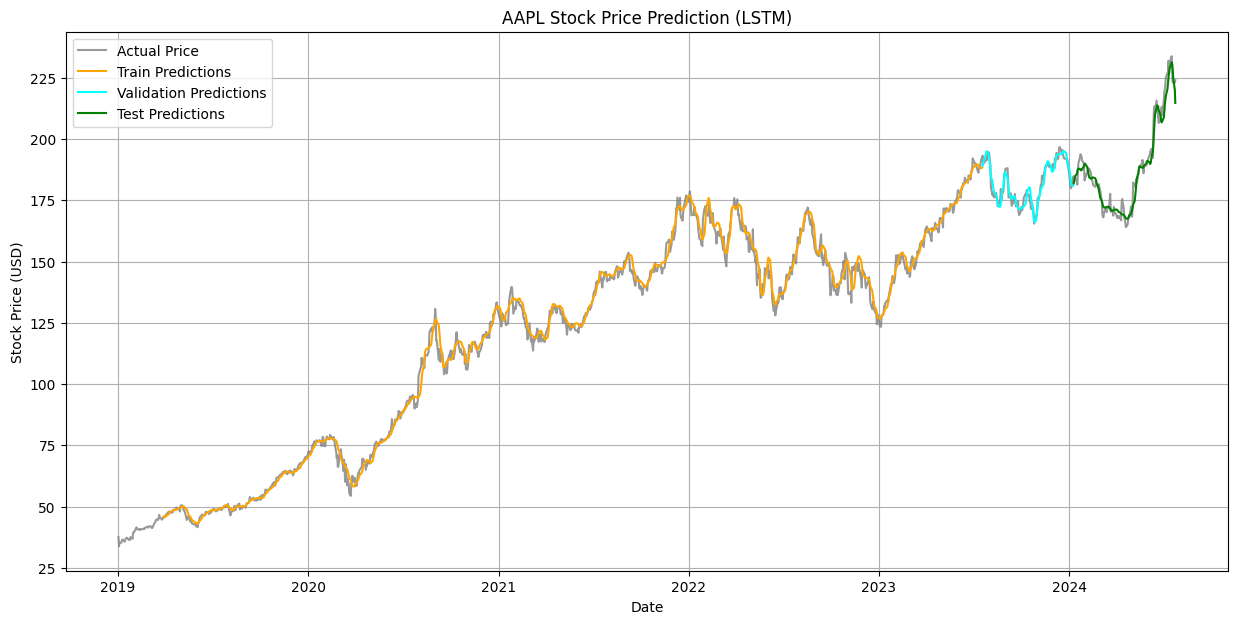


--- Predicting Future Prices ---
Predicted prices for the next 7 days:
2024-07-24: $207.21
2024-07-25: $201.05
2024-07-26: $196.19
2024-07-27: $192.68
2024-07-28: $190.30
2024-07-29: $188.76
2024-07-30: $187.69


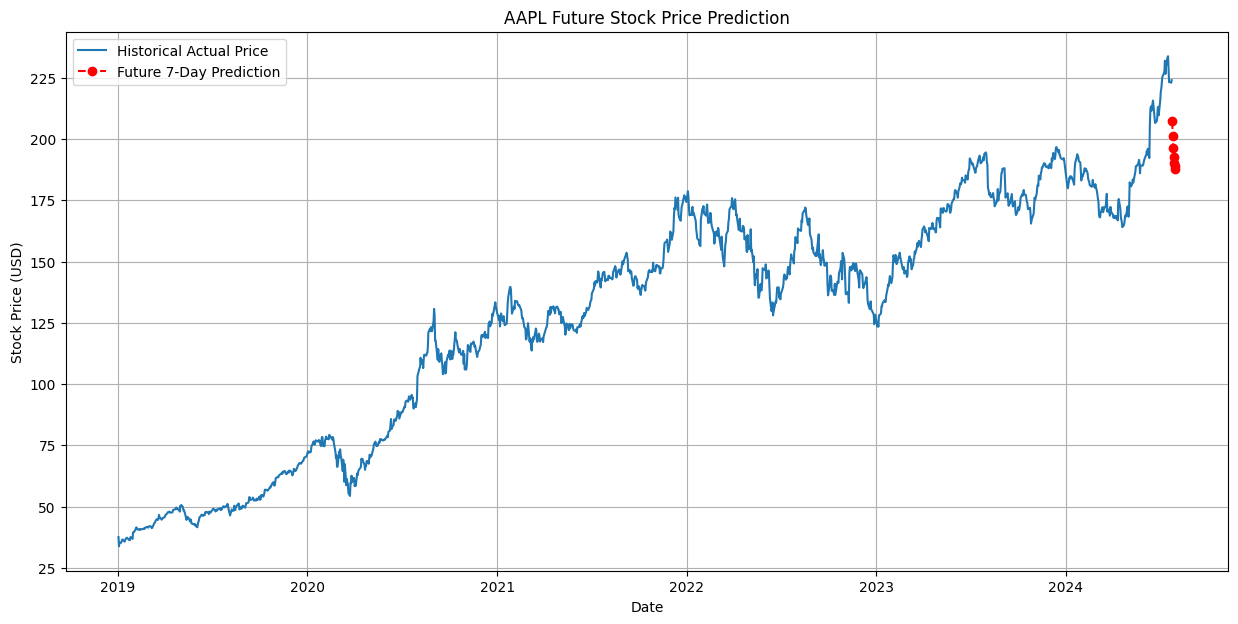


Cleaned up saved model: best_stock_predictor.pth

--- Project Demonstration Complete ---


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pywt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import timedelta
import os


# --- 1. Configuration ---
def get_config():
    """Returns a dictionary of configuration parameters."""
    return {
        "ticker": "AAPL",
        "start_date": "2019-01-01",
        "end_date": "2024-07-24",
        "test_size": 0.1, # Proportion of data for testing
        "validation_size": 0.1, # Proportion of training data for validation
        "look_back": 60,
        "wavelet": "db4",
        "wavelet_level": 3,
        "model_type": "LSTM",  # "LSTM" or "GRU"
        "hidden_layer_size": 50,
        "num_layers": 2,
        "dropout": 0.2,
        "epochs": 100,
        "batch_size": 32,
        "learning_rate": 0.001,
        "patience": 10,  # For early stopping
        "future_days_to_predict": 7,
        "device": "cuda" if torch.cuda.is_available() else "cpu",
        "model_save_path": "best_stock_predictor.pth"
    }

# --- 2. Data Handling ---------------------------------------------------------------------------------
def download_data(ticker, start, end):
    """Downloads stock data from Yahoo Finance."""
    print(f"Downloading data for {ticker} from {start} to {end}...")
    try:
        df = yf.download(ticker, start=start, end=end, progress=False)
        if df.empty:
            raise ValueError("No data downloaded. Check ticker or date range.")
        print(f"Successfully downloaded {len(df)} rows of data.")
        return df
    except Exception as e:
        print(f"Error downloading data: {e}")
        return None

#---------Preprocessing-----------------------------------------------------------------------------
def preprocess_data(data, wavelet, level):
    """Normalizes and denoises the data."""
    print("Preprocessing data...")
    # Normalize
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # Denoise using wavelet transform
    def wavelet_denoise(data, wavelet, level):
        coeffs = pywt.wavedec(data, wavelet, mode="per", level=level)
        sigma = (1/0.6745) * np.median(np.abs(coeffs[-level] - np.median(coeffs[-level])))
        threshold = sigma * np.sqrt(2 * np.log(len(data)))
        denoised_coeffs = [coeffs[0]] + [pywt.threshold(c, value=threshold, mode='soft') for c in coeffs[1:]]
        denoised_data = pywt.waverec(denoised_coeffs, wavelet, mode="per")
        return denoised_data[:len(data)]

    denoised_scaled_data = wavelet_denoise(scaled_data.flatten(), wavelet, level).reshape(-1, 1)
    print("Data normalized and denoised.")
    return denoised_scaled_data, scaler

def create_sequences(data, look_back):
    """Creates input/output sequences for the model."""
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

# --- 3. Model Definition -------------------------------------------------------------------------
class StockPredictor(nn.Module):
    """Flexible LSTM/GRU based stock prediction model."""
    def __init__(self, input_size=1, hidden_layer_size=50, num_layers=2, output_size=1, dropout=0.2, model_type="LSTM"):
        super().__init__()
        if model_type == "LSTM":
            self.model = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True, dropout=dropout)
        elif model_type == "GRU":
            self.model = nn.GRU(input_size, hidden_layer_size, num_layers, batch_first=True, dropout=dropout)
        else:
            raise ValueError("Model type must be 'LSTM' or 'GRU'")

        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        model_out, _ = self.model(input_seq)
        # We only want the output of the last time step
        predictions = self.linear(model_out[:, -1, :])
        return predictions

# --- 4. Training and Evaluation -----------------------------------------------------------------------------
def train_model(model, config, train_loader, val_loader):
    """Trains the model with validation and early stopping."""
    print("\n--- Starting Model Training ---")
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])

    min_val_loss = np.inf
    epochs_no_improve = 0
    history = {"train_loss": [], "val_loss": []}

    for epoch in range(config["epochs"]):
        # Training
        model.train()
        train_loss = 0
        for seq, labels in train_loader:
            seq, labels = seq.to(config["device"]), labels.to(config["device"])

            optimizer.zero_grad()
            y_pred = model(seq)
            loss = loss_function(y_pred, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        history["train_loss"].append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for seq, labels in val_loader:
                seq, labels = seq.to(config["device"]), labels.to(config["device"])
                y_pred = model(seq)
                loss = loss_function(y_pred, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        history["val_loss"].append(avg_val_loss)

        print(f"Epoch {epoch+1}/{config['epochs']} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

        # Early stopping and model checkpointing
        if avg_val_loss < min_val_loss:
            min_val_loss = avg_val_loss
            torch.save(model.state_dict(), config["model_save_path"])
            epochs_no_improve = 0
            print(f"Validation loss decreased. Saving model to {config['model_save_path']}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve == config["patience"]:
                print(f"Early stopping triggered after {config['patience']} epochs with no improvement.")
                break

    print("--- Training Complete ---")
    # Load the best model
    model.load_state_dict(torch.load(config["model_save_path"]))
    return model, history

#----------Evaluating-------------------------------------------------------------------------------

def evaluate_model(model, X, y, scaler, set_name, device):
    """Calculates and prints evaluation metrics."""
    model.eval()
    with torch.no_grad():
        X_tensor = torch.from_numpy(X).float().unsqueeze(-1).to(device)
        predictions_scaled = model(X_tensor).cpu().numpy()

    predictions = scaler.inverse_transform(predictions_scaled)
    actuals = scaler.inverse_transform(y.reshape(-1, 1))

    # --- ADD THIS CODE ---
    if set_name == "Test":
        print("\n--- Sample Test Set Predictions vs Actuals ---")
        # Print the first 15 predictions for a sample view
        for i in range(min(15, len(actuals))):
            print(f"Actual: ${actuals[i][0]:.2f}, Predicted: ${predictions[i][0]:.2f}")
    # ---------------------

    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / np.where(actuals == 0, 1, actuals))) * 100

    print(f"\n--- {set_name} Set Metrics ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R2 Score: {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")

    return predictions

# --- 5. Visualization ----------------------------------------------------------------------------------
def plot_training_history(history):
    """Plots the training and validation loss."""
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_predictions(df, look_back, train_preds, val_preds, test_preds, config):
    """Plots the actual prices against the model's predictions."""
    plt.figure(figsize=(15, 7))

    # Plot actual price
    plt.plot(df.index, df['Close'], color='gray', alpha=0.8, label='Actual Price')

    # Create plot dataframes
    train_plot_index = df.index[look_back:len(train_preds) + look_back]
    # Corrected validation plot index
    val_plot_index = df.index[len(train_preds) + look_back : len(train_preds) + len(val_preds) + look_back]
    test_plot_index = df.index[-len(test_preds):]


    # Plot predictions
    plt.plot(train_plot_index, train_preds, color='orange', label='Train Predictions')
    plt.plot(val_plot_index, val_preds, color='cyan', label='Validation Predictions')
    plt.plot(test_plot_index, test_preds, color='green', label='Test Predictions')

    plt.title(f'{config["ticker"]} Stock Price Prediction ({config["model_type"]})')
    plt.xlabel('Date')
    plt.ylabel('Stock Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()

# --- 6. Future Prediction ------------------------------------------------------------------------------------
def predict_future(model, data, scaler, config):
    """Predicts future stock prices."""
    print("\n--- Predicting Future Prices ---")
    model.eval()

    last_sequence = data[-config["look_back"]:]
    current_sequence = torch.FloatTensor(last_sequence).view(1, config["look_back"], 1).to(config["device"])
    future_predictions_scaled = []

    for _ in range(config["future_days_to_predict"]):
        with torch.no_grad():
            next_pred_scaled = model(current_sequence)
            future_predictions_scaled.append(next_pred_scaled.cpu().item())
            # Update the sequence
            current_sequence = torch.cat((current_sequence[:, 1:, :], next_pred_scaled.view(1, 1, 1)), dim=1)

    future_predictions = scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1))

    print(f"Predicted prices for the next {config['future_days_to_predict']} days:")
    return future_predictions

def plot_future(df, future_preds, config):
    """Plots historical data and future predictions."""
    plt.figure(figsize=(15, 7))
    last_date = df.index[-1]

    # Plot historical data
    plt.plot(df.index, df['Close'], label='Historical Actual Price')

    # Create future dates for plotting
    future_dates = pd.to_datetime([last_date + timedelta(days=i + 1) for i in range(config["future_days_to_predict"])])

    # Plot future predictions
    plt.plot(future_dates, future_preds, color='red', marker='o', linestyle='--', label=f'Future {config["future_days_to_predict"]}-Day Prediction')

    plt.title(f'{config["ticker"]} Future Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Stock Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()


# --- Main Execution ------------------------------------------------------------------------
def main():
    """Main function to run the stock prediction pipeline."""
    # Get configuration
    config = get_config()
    print(f"Using device: {config['device']}")
    print(f"Model type: {config['model_type']}")

    # 1. Data Collection and Preprocessing
    df = download_data(config["ticker"], config["start_date"], config["end_date"])
    if df is None:
        return

    close_prices = df['Close'].values.reshape(-1, 1)
    denoised_data, scaler = preprocess_data(close_prices, config["wavelet"], config["wavelet_level"])

    # 2. Create Sequences and Split Data
    X, y = create_sequences(denoised_data, config["look_back"])

    # Split into train, validation, and test sets
    test_split_index = int(len(X) * (1 - config["test_size"]))
    X_train_val, X_test = X[:test_split_index], X[test_split_index:]
    y_train_val, y_test = y[:test_split_index], y[test_split_index:]

    val_split_index = int(len(X_train_val) * (1 - config["validation_size"]))
    X_train, X_val = X_train_val[:val_split_index], X_train_val[val_split_index:]
    y_train, y_val = y_train_val[:val_split_index], y_train_val[val_split_index:]

    print(f"Data split sizes:")
    print(f"Train: {len(X_train)} | Validation: {len(X_val)} | Test: {len(X_test)}")

    # 3. Create PyTorch DataLoaders
    X_train_t = torch.from_numpy(X_train).float().unsqueeze(-1)
    y_train_t = torch.from_numpy(y_train).float().view(-1, 1)
    train_dataset = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)

    X_val_t = torch.from_numpy(X_val).float().unsqueeze(-1)
    y_val_t = torch.from_numpy(y_val).float().view(-1, 1)
    val_dataset = TensorDataset(X_val_t, y_val_t)
    val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)

    # 4. Initialize and Train Model
    model = StockPredictor(
        hidden_layer_size=config["hidden_layer_size"],
        num_layers=config["num_layers"],
        dropout=config["dropout"],
        model_type=config["model_type"]
    ).to(config["device"])

    print("\n--- Model Architecture ---")
    print(model)

    model, history = train_model(model, config, train_loader, val_loader)
    plot_training_history(history)

    # 5. Evaluate Model
    print("\n--- Final Model Evaluation ---")
    train_predictions = evaluate_model(model, X_train, y_train, scaler, "Training", config["device"])
    val_predictions = evaluate_model(model, X_val, y_val, scaler, "Validation", config["device"])
    test_predictions = evaluate_model(model, X_test, y_test, scaler, "Test", config["device"])

    # 6. Visualize Predictions
    plot_predictions(df, config["look_back"], train_predictions, val_predictions, test_predictions, config)

    # 7. Predict and Visualize Future
    future_predictions = predict_future(model, denoised_data, scaler, config)

    last_date = df.index[-1]
    for i, price in enumerate(future_predictions.flatten()):
        prediction_date = last_date + timedelta(days=i + 1)
        print(f"{prediction_date.strftime('%Y-%m-%d')}: ${price:.2f}")

    plot_future(df, future_predictions, config)

    # Clean up saved model
    if os.path.exists(config["model_save_path"]):
        os.remove(config["model_save_path"])
        print(f"\nCleaned up saved model: {config['model_save_path']}")


main()
print("\n--- Project Demonstration Complete ---")

# WAVELET +  TRANSFORMER

Using device: cuda
Model type: Transformer
Successfully downloaded 1397 rows of data.
Preprocessing data...
Data normalized and denoised.
Data split sizes: Train: 1082 | Validation: 121 | Test: 134

--- Model Architecture ---
StockPredictorTransformer(
  (input_embedding): Linear(in_features=1, out_features=64, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=Tru

/tmp/ipython-input-4-3227130871.py:52: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)


Epoch 1/100 | Train Loss: 0.080721 | Val Loss: 0.026066
Validation loss decreased. Saving model to best_transformer_predictor.pth
Epoch 2/100 | Train Loss: 0.013855 | Val Loss: 0.008181
Validation loss decreased. Saving model to best_transformer_predictor.pth
Epoch 3/100 | Train Loss: 0.008398 | Val Loss: 0.007231
Validation loss decreased. Saving model to best_transformer_predictor.pth
Epoch 4/100 | Train Loss: 0.006348 | Val Loss: 0.001636
Validation loss decreased. Saving model to best_transformer_predictor.pth
Epoch 5/100 | Train Loss: 0.006474 | Val Loss: 0.004203
Epoch 6/100 | Train Loss: 0.004826 | Val Loss: 0.004294
Epoch 7/100 | Train Loss: 0.004422 | Val Loss: 0.002211
Epoch 8/100 | Train Loss: 0.003880 | Val Loss: 0.002874
Epoch 9/100 | Train Loss: 0.003606 | Val Loss: 0.000855
Validation loss decreased. Saving model to best_transformer_predictor.pth
Epoch 10/100 | Train Loss: 0.003132 | Val Loss: 0.001704
Epoch 11/100 | Train Loss: 0.002875 | Val Loss: 0.001335
Epoch 12/100

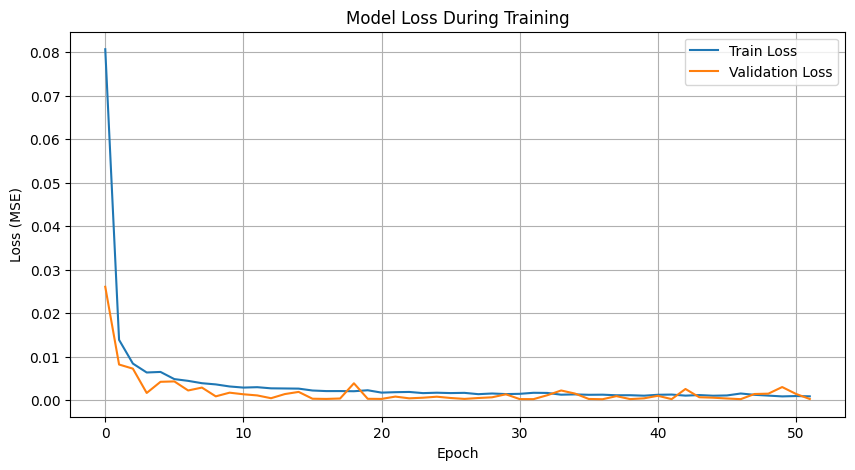


--- Final Model Evaluation ---

--- Training Set Metrics ---
RMSE: 2.5417
MAE:  2.0701
R2 Score: 0.9937
MAPE: 1.53%

--- Validation Set Metrics ---
RMSE: 2.7987
MAE:  2.3024
R2 Score: 0.9335
MAPE: 1.00%

--- Sample Test Set Predictions vs Actuals ---
Actual: $237.60, Predicted: $242.45
Actual: $234.85, Predicted: $240.95
Actual: $232.00, Predicted: $239.14
Actual: $228.95, Predicted: $237.18
Actual: $226.89, Predicted: $235.02
Actual: $225.98, Predicted: $233.41
Actual: $225.59, Predicted: $232.47
Actual: $226.07, Predicted: $231.86
Actual: $226.81, Predicted: $231.80
Actual: $227.79, Predicted: $231.93
Actual: $229.64, Predicted: $232.23
Actual: $232.25, Predicted: $233.12
Actual: $233.77, Predicted: $234.53
Actual: $234.15, Predicted: $235.38
Actual: $234.20, Predicted: $235.63

--- Test Set Metrics ---
RMSE: 5.4040
MAE:  4.3071
R2 Score: 0.8716
MAPE: 2.05%


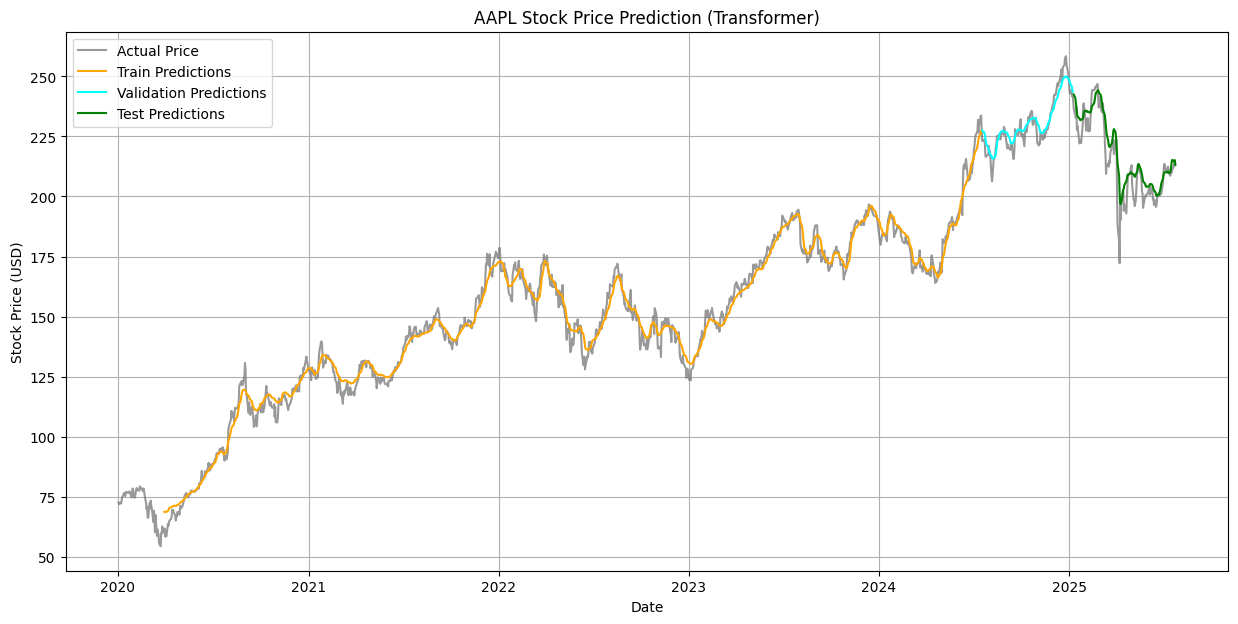


--- Predicting Future Prices ---
Predicted prices for the next 14 days:
2025-07-25: $208.61
2025-07-26: $211.54
2025-07-27: $213.50
2025-07-28: $214.80
2025-07-29: $215.76
2025-07-30: $216.61
2025-07-31: $217.42
2025-08-01: $218.17
2025-08-02: $218.87
2025-08-03: $219.51
2025-08-04: $220.08
2025-08-05: $220.62
2025-08-06: $221.16
2025-08-07: $221.71


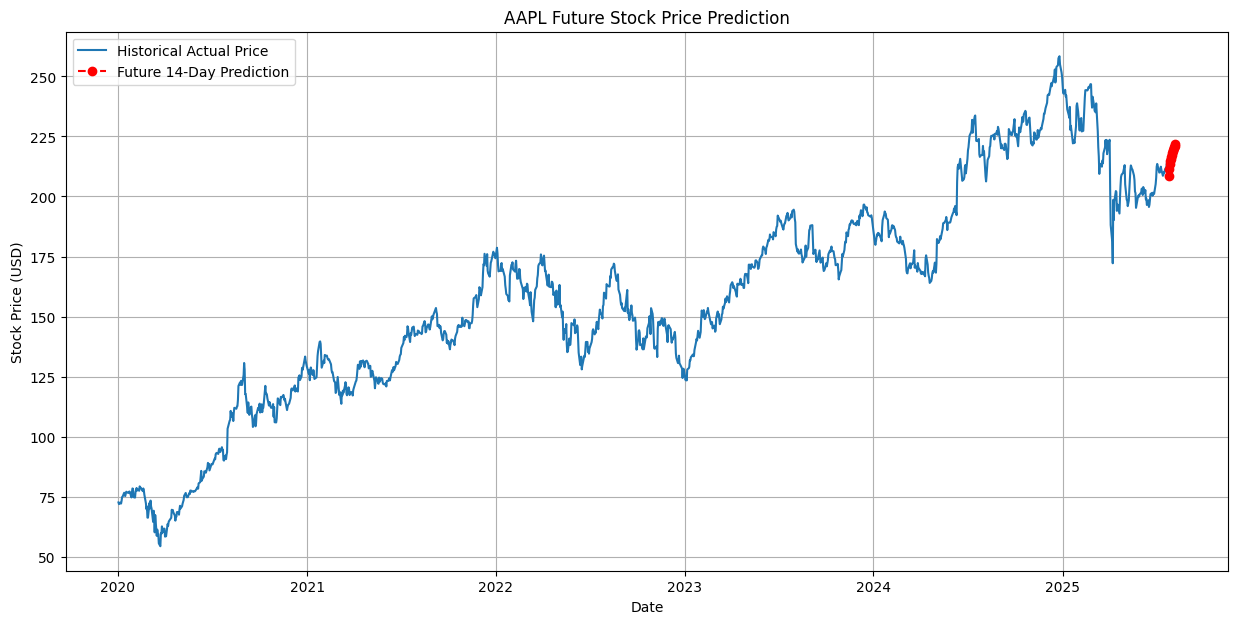


Cleaned up saved model: best_transformer_predictor.pth

--- Project Demonstration Complete ---


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pywt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import timedelta
import os
import math


# --- 1. Configuration ---
def get_config():
    """Returns a dictionary of configuration parameters."""
    return {
        # Data and Preprocessing
        "ticker": "AAPL",
        "start_date": "2020-01-01",
        "end_date": "2025-07-25", # Set to current date
        "test_size": 0.1,
        "validation_size": 0.1,
        "look_back": 60,
        "wavelet": "db4",
        "wavelet_level": 3,

        # Transformer Model Hyperparameters
        "d_model": 64,  # Embedding dimension (must be divisible by nhead)
        "nhead": 4,  # Number of attention heads
        "num_encoder_layers": 3,
        "dim_feedforward": 256,  # Dimension of the feedforward network
        "model_dropout": 0.1,

        # Training
        "epochs": 100,
        "batch_size": 32,
        "learning_rate": 0.0005,
        "patience": 15,
        "future_days_to_predict": 14,
        "device": "cuda" if torch.cuda.is_available() else "cpu",
        "model_save_path": "best_transformer_predictor.pth"
    }

# --- 2. Data Handling ---
def download_data(ticker, start, end):
    """Downloads stock data from Yahoo Finance."""
    print(f"Downloading data for {ticker} from {start} to {end}...")
    try:
        df = yf.download(ticker, start=start, end=end, progress=False)
        if df.empty:
            raise ValueError("No data downloaded. Check ticker or date range.")
        print(f"Successfully downloaded {len(df)} rows of data.")
        return df
    except Exception as e:
        print(f"Error downloading data: {e}")
        return None

def preprocess_data(data, wavelet, level):
    """Normalizes and denoises the data."""
    print("Preprocessing data...")
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    def wavelet_denoise(data, wavelet, level):
        coeffs = pywt.wavedec(data, wavelet, mode="per", level=level)
        sigma = (1/0.6745) * np.median(np.abs(coeffs[-level] - np.median(coeffs[-level])))
        threshold = sigma * np.sqrt(2 * np.log(len(data)))
        denoised_coeffs = [coeffs[0]] + [pywt.threshold(c, value=threshold, mode='soft') for c in coeffs[1:]]
        denoised_data = pywt.waverec(denoised_coeffs, wavelet, mode="per")
        return denoised_data[:len(data)]

    denoised_scaled_data = wavelet_denoise(scaled_data.flatten(), wavelet, level).reshape(-1, 1)
    print("Data normalized and denoised.")
    return denoised_scaled_data, scaler

def create_sequences(data, look_back):
    """Creates input/output sequences for the model."""
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

# --- 3. Transformer Model Definition ------------------------------------------------------
class PositionalEncoding(nn.Module):
    """Injects positional information into the input embeddings."""
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class StockPredictorTransformer(nn.Module):
    """Transformer-based stock prediction model."""
    def __init__(self, config):
        super(StockPredictorTransformer, self).__init__()
        self.d_model = config["d_model"]

        # 1. Input Embedding
        self.input_embedding = nn.Linear(1, self.d_model)

        # 2. Positional Encoding
        self.pos_encoder = PositionalEncoding(self.d_model, config["model_dropout"])

        # 3. Transformer Encoder
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=self.d_model,
            nhead=config["nhead"],
            dim_feedforward=config["dim_feedforward"],
            dropout=config["model_dropout"],
            batch_first=True # Important for our data shape
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=config["num_encoder_layers"])

        # 4. Output Layer
        self.output_layer = nn.Linear(self.d_model, 1)

    def forward(self, src):
        # src shape: [batch_size, seq_len, features=1]

        # Embed input and add positional encoding
        src = self.input_embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src.transpose(0,1)).transpose(0,1) # PositionalEncoding expects [seq_len, batch_size, d_model]

        # Pass through transformer encoder
        output = self.transformer_encoder(src)

        # We take the output of the last time step to make a prediction
        output = self.output_layer(output[:, -1, :])
        return output

# --- 4. Training and Evaluation (Identical to previous script) ---
def train_model(model, config, train_loader, val_loader):
    """Trains the model with validation and early stopping."""
    print("\n--- Starting Model Training ---")
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])

    min_val_loss = np.inf
    epochs_no_improve = 0
    history = {"train_loss": [], "val_loss": []}

    for epoch in range(config["epochs"]):
        model.train()
        train_loss = 0
        for seq, labels in train_loader:
            seq, labels = seq.to(config["device"]), labels.to(config["device"])
            optimizer.zero_grad()
            y_pred = model(seq)
            loss = loss_function(y_pred, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        history["train_loss"].append(avg_train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for seq, labels in val_loader:
                seq, labels = seq.to(config["device"]), labels.to(config["device"])
                y_pred = model(seq)
                loss = loss_function(y_pred, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        history["val_loss"].append(avg_val_loss)

        print(f"Epoch {epoch+1}/{config['epochs']} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

        if avg_val_loss < min_val_loss:
            min_val_loss = avg_val_loss
            torch.save(model.state_dict(), config["model_save_path"])
            epochs_no_improve = 0
            print(f"Validation loss decreased. Saving model to {config['model_save_path']}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= config["patience"]:
                print(f"Early stopping triggered after {config['patience']} epochs with no improvement.")
                break

    print("--- Training Complete ---")
    model.load_state_dict(torch.load(config["model_save_path"]))
    return model, history

def evaluate_model(model, X, y, scaler, set_name, device):
    """Calculates and prints evaluation metrics."""
    model.eval()
    with torch.no_grad():
        X_tensor = torch.from_numpy(X).float().unsqueeze(-1).to(device)
        predictions_scaled = model(X_tensor).cpu().numpy()

    predictions = scaler.inverse_transform(predictions_scaled)
    actuals = scaler.inverse_transform(y.reshape(-1, 1))

    # --- Printing the predicted vs original  ---
    if set_name == "Test":
        print("\n--- Sample Test Set Predictions vs Actuals ---")
        # Print the first 15 predictions for a sample view
        for i in range(min(15, len(actuals))):
            print(f"Actual: ${actuals[i][0]:.2f}, Predicted: ${predictions[i][0]:.2f}")
    # ---------------------

    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / np.where(actuals == 0, 1, actuals))) * 100

    print(f"\n--- {set_name} Set Metrics ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R2 Score: {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")

    return predictions

# --- 5. Visualization ----------------------------------------------------
def plot_training_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_predictions(df, look_back, train_preds, val_preds, test_preds, config):
    plt.figure(figsize=(15, 7))
    plt.plot(df.index, df['Close'], color='gray', alpha=0.8, label='Actual Price')

    train_plot_index = df.index[look_back:len(train_preds) + look_back]
    # Corrected validation plot index calculation
    val_plot_index = df.index[len(train_preds) + look_back : len(train_preds) + len(val_preds) + look_back]
    test_plot_index = df.index[-len(test_preds):]

    plt.plot(train_plot_index, train_preds, color='orange', label='Train Predictions')
    plt.plot(val_plot_index, val_preds, color='cyan', label='Validation Predictions')
    plt.plot(test_plot_index, test_preds, color='green', label='Test Predictions')

    plt.title(f'{config["ticker"]} Stock Price Prediction (Transformer)')
    plt.xlabel('Date')
    plt.ylabel('Stock Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()

# --- 6. Future Prediction----------------------------------------------------------------
def predict_future(model, data, scaler, config):
    print("\n--- Predicting Future Prices ---")
    model.eval()

    last_sequence = data[-config["look_back"]:]
    current_sequence = torch.FloatTensor(last_sequence).view(1, config["look_back"], 1).to(config["device"])
    future_predictions_scaled = []

    for _ in range(config["future_days_to_predict"]):
        with torch.no_grad():
            next_pred_scaled = model(current_sequence)
            future_predictions_scaled.append(next_pred_scaled.cpu().item())
            current_sequence = torch.cat((current_sequence[:, 1:, :], next_pred_scaled.view(1, 1, 1)), dim=1)

    future_predictions = scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1))

    print(f"Predicted prices for the next {config['future_days_to_predict']} days:")
    return future_predictions

def plot_future(df, future_preds, config):
    plt.figure(figsize=(15, 7))
    last_date = df.index[-1]
    plt.plot(df.index, df['Close'], label='Historical Actual Price')
    future_dates = pd.to_datetime([last_date + timedelta(days=i + 1) for i in range(config["future_days_to_predict"])])
    plt.plot(future_dates, future_preds, color='red', marker='o', linestyle='--', label=f'Future {config["future_days_to_predict"]}-Day Prediction')
    plt.title(f'{config["ticker"]} Future Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Stock Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()

# --- Main Execution -----------------------------------------------------------------------
def main():
    config = get_config()
    print(f"Using device: {config['device']}")
    print("Model type: Transformer")

    df = download_data(config["ticker"], config["start_date"], config["end_date"])
    if df is None: return

    close_prices = df['Close'].values.reshape(-1, 1)
    denoised_data, scaler = preprocess_data(close_prices, config["wavelet"], config["wavelet_level"])

    X, y = create_sequences(denoised_data, config["look_back"])

    test_split_index = int(len(X) * (1 - config["test_size"]))
    X_train_val, X_test = X[:test_split_index], X[test_split_index:]
    y_train_val, y_test = y[:test_split_index], y[test_split_index:]

    val_split_index = int(len(X_train_val) * (1 - config["validation_size"]))
    X_train, X_val = X_train_val[:val_split_index], X_train_val[val_split_index:]
    y_train, y_val = y_train_val[:val_split_index], y_train_val[val_split_index:]

    print(f"Data split sizes: Train: {len(X_train)} | Validation: {len(X_val)} | Test: {len(X_test)}")

    X_train_t = torch.from_numpy(X_train).float().unsqueeze(-1)
    y_train_t = torch.from_numpy(y_train).float().view(-1, 1)
    train_dataset = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)

    X_val_t = torch.from_numpy(X_val).float().unsqueeze(-1)
    y_val_t = torch.from_numpy(y_val).float().view(-1, 1)
    val_dataset = TensorDataset(X_val_t, y_val_t)
    val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)

    model = StockPredictorTransformer(config).to(config["device"])

    print("\n--- Model Architecture ---")
    print(model)

    model, history = train_model(model, config, train_loader, val_loader)
    plot_training_history(history)

    print("\n--- Final Model Evaluation ---")
    train_predictions = evaluate_model(model, X_train, y_train, scaler, "Training", config["device"])
    val_predictions = evaluate_model(model, X_val, y_val, scaler, "Validation", config["device"])
    test_predictions = evaluate_model(model, X_test, y_test, scaler, "Test", config["device"])

    plot_predictions(df, config["look_back"], train_predictions, val_predictions, test_predictions, config)

    future_predictions = predict_future(model, denoised_data, scaler, config)

    last_date = df.index[-1]
    for i, price in enumerate(future_predictions.flatten()):
        prediction_date = last_date + timedelta(days=i + 1)
        print(f"{prediction_date.strftime('%Y-%m-%d')}: ${price:.2f}")

    plot_future(df, future_predictions, config)

    if os.path.exists(config["model_save_path"]):
        os.remove(config["model_save_path"])
        print(f"\nCleaned up saved model: {config['model_save_path']}")


main()
print("\n--- Project Demonstration Complete ---")